# HourVideo: GPT-4 Demo

Welcome to the demo for **HourVideo**! 

Here, you’ll learn how to run inference on an hour-long video using **GPT-4** and evaluate its performance on tasks introduced in HourVideo.

## **Goal of the Demo**

In this demo, you will:
1. **Load an hour-long video** from the HourVideo benchmark dataset.
2. **Run inference** using the Socratic Models approach (Caption + QA):
   - Caption the video using **GPT-4o**.
   - Answer questions about the video using **GPT-4-turbo**.
3. **Evaluate the performance** of the baseline model using ground-truth labels across four tasks:
   - Summarization
   - Perception (recall, tracking)
   - Visual Reasoning (spatial, temporal, predictive, causal, counterfactual)
   - Navigation (room-to-room, object retrieval)

This demo is designed to be straightforward. Let's begin!


## 1. Import HourVideo and other modules

In [ ]:
# Import base libraries
import os
import argparse
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Import HourVideo
from hourvideo import hv_utils
from hourvideo import gpt4_captioner
from hourvideo import gpt4_qa

## 2. Load Video, Benchmark and Visualize the data.

In [ ]:
VIDEO_UID = '6fd90f8d-7a4d-425d-a812-3268db0b0342'
VIDEO_DIR = '../benchmark/HourVideo/demo_video/' # Place video here
BENCHMARK_JSON_PATH = '../benchmark/HourVideo/v1.0_release/json/samples_v1.0.json'
BENCHMARK_IMAGES_DIR = '../benchmark/HourVideo/v1.0_release/' # This is where the sketches are stored.
video_path = os.path.join(VIDEO_DIR, f'{VIDEO_UID}.mp4')

if not (os.path.exists(video_path) and os.path.exists(BENCHMARK_JSON_PATH)):
    print("Please download the video and benchmark first")
else:
    print("Great! Proceed to next step now.")

Great! Proceed to next step now.


### 2.1 Visualize the Video and Extract Frames for Captioning.
1. Load the video.
2. Extract frames at a sampling rate of 0.5 fps, resizing the longer dimension to 512 px, and save these frames to: ```../assets/demo/gpt-4/frames/```. 

Note: This process may take some time, as approximately 1,800 frames will be extracted.

In [3]:
# Set parameters and path to save extracted frames
FRAMES_SAVE_PARENT_DIR = f'../assets/demo/gpt-4o/frames/'
FRAMES_SAVE_DIR = f'{FRAMES_SAVE_PARENT_DIR}/{VIDEO_UID}'
SAMPLING_FPS = 0.5
RESIZE=512

In [ ]:
# Extract frames (Will take about 5 mins)
extracted_frames = hv_utils.load_video(video_path, SAMPLING_FPS, size=RESIZE, verbose=True)

# Save the extracted frames for captioning
hv_utils.save_extracted_frames(extracted_frames, FRAMES_SAVE_DIR)

> Reading video: ../HourVideo/demo_video/6fd90f8d-7a4d-425d-a812-3268db0b0342.mp4
Stats=> fps:30.0, #frames:107941, sampling fps:0.5, #sampled_frames:1800
Number of frames sampled: torch.Size([1800, 3, 1080, 1440])
Number of frames sampled (spatial downsampled): torch.Size([1800, 3, 384, 512])


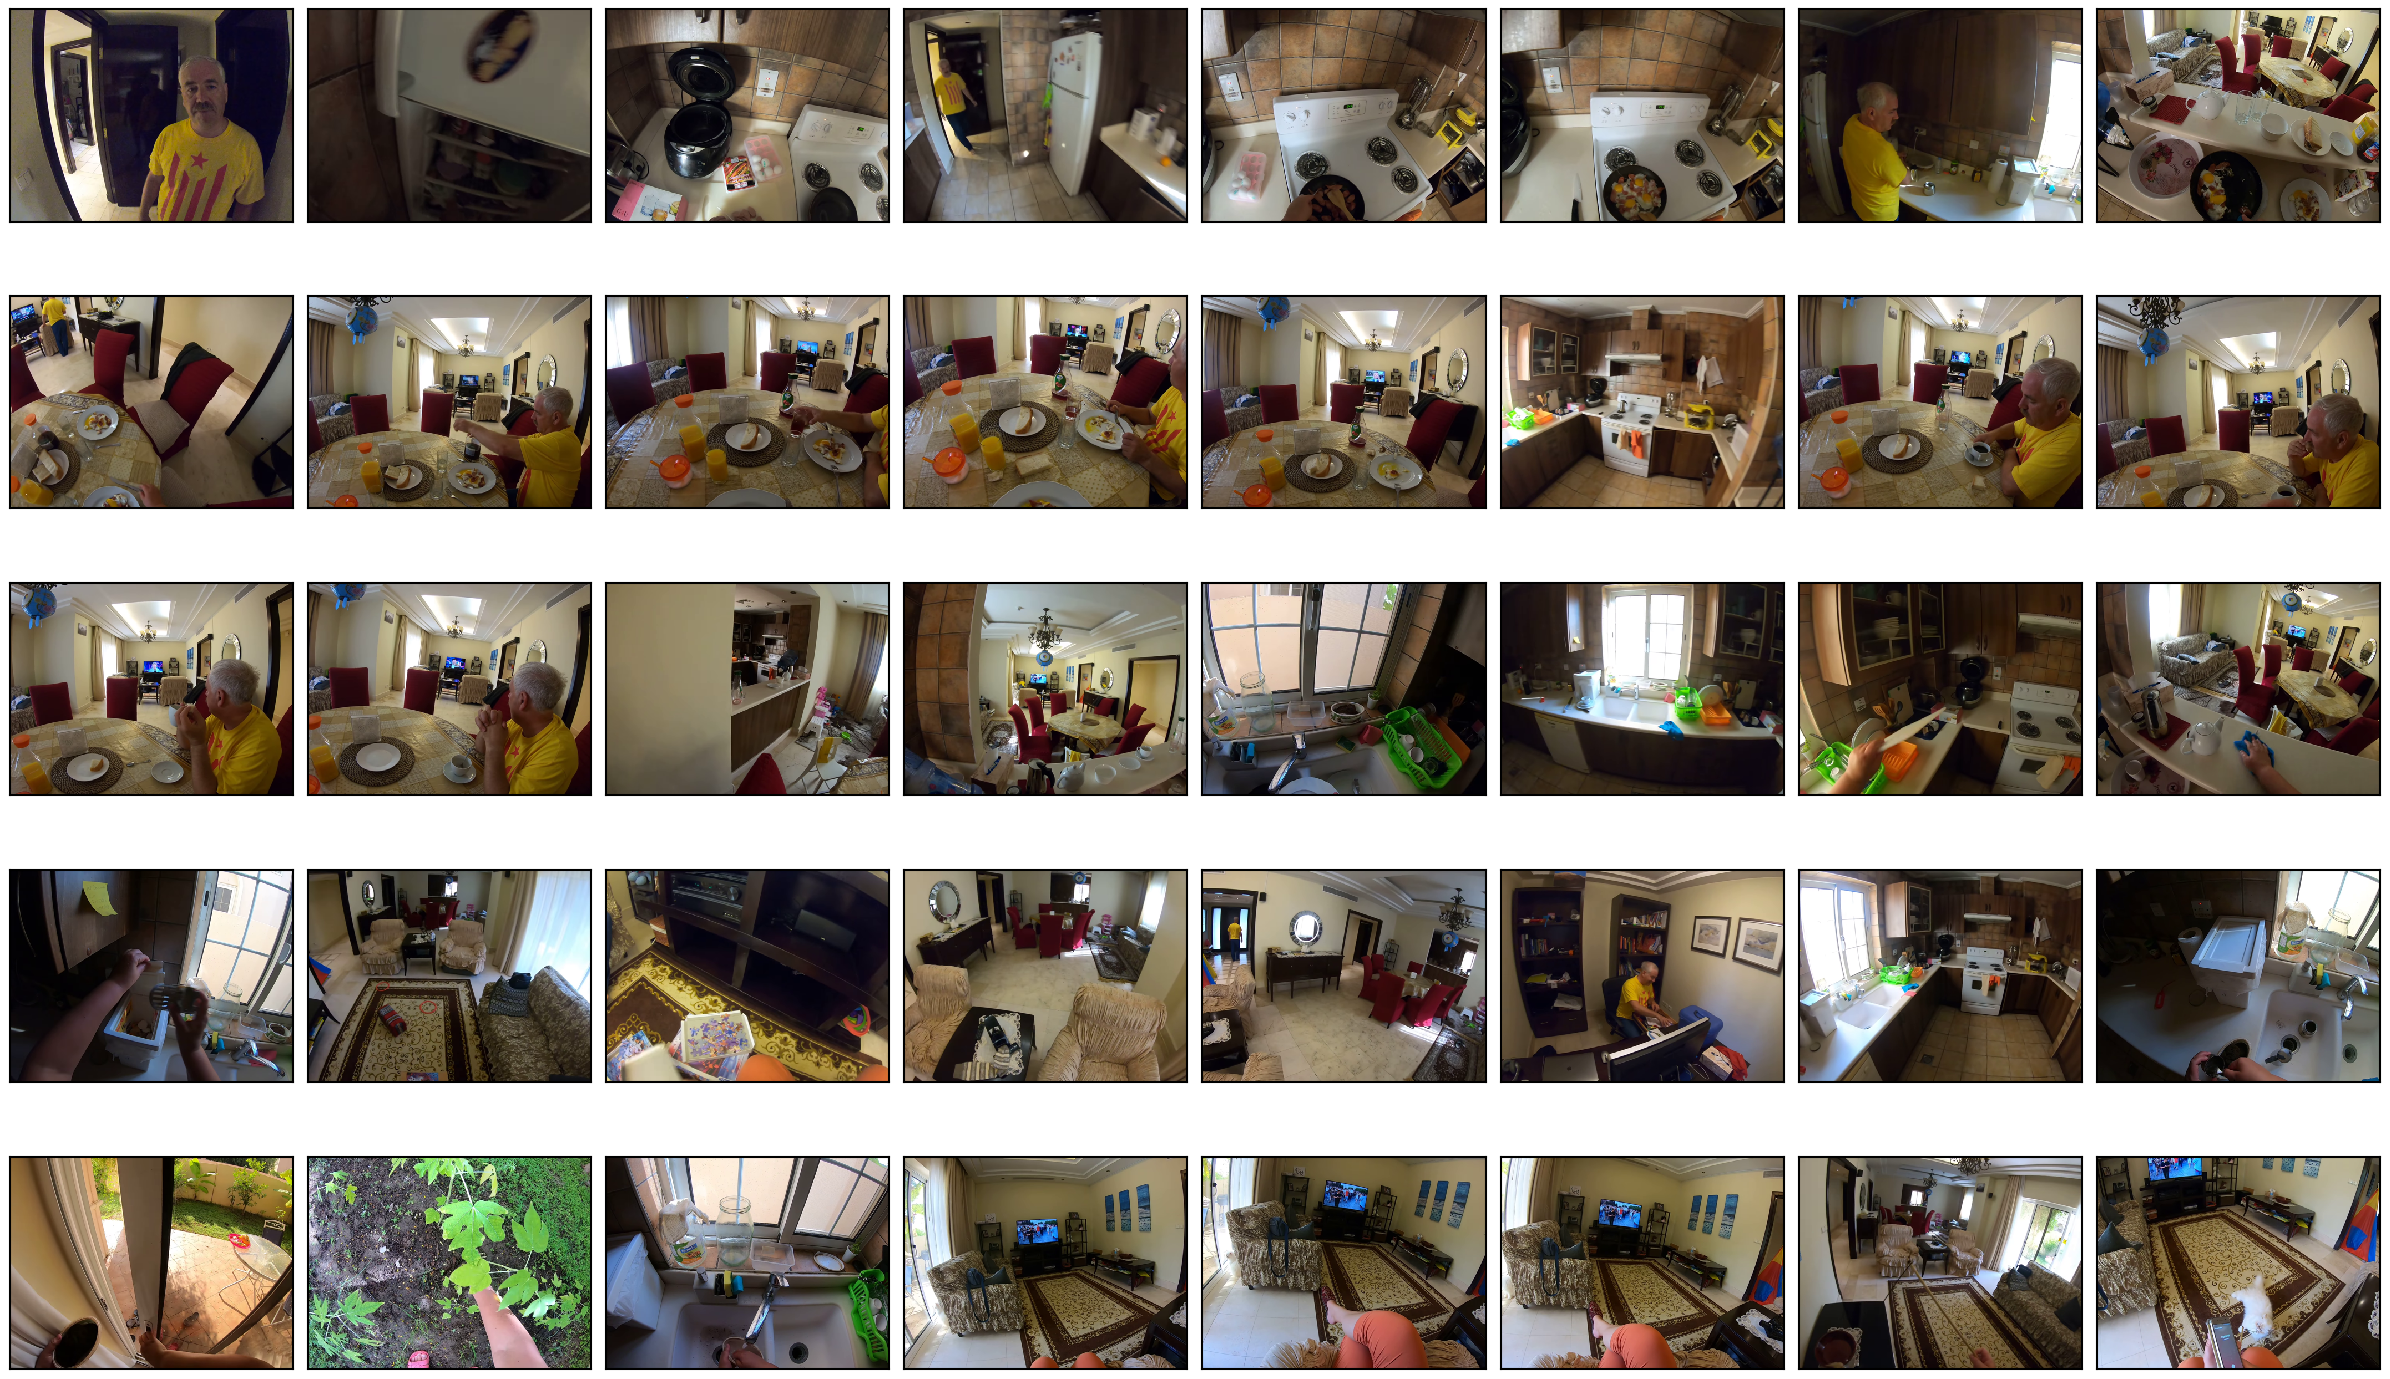

In [5]:
# Visualize video (visualize 40 frames uniformly sampled)
hv_utils.visualize_video(extracted_frames, save_name="../assets/demo/gpt-4o/video_frame_collage.png") # Visualize frames uniformly sampled from the video.

### 2.2 Prepare the Benchmark Data

In this step, we will perform the following tasks:

1. Load the HourVideo benchmark to extract the video metadata as a dictionary and the multiple-choice questions (MCQs) as a pandas DataFrame.
2. Visualize the task distribution of MCQs for this video.
3. Prepare the DataFrame for evaluation, following the protocol introduced in HourVideo (https://arxiv.org/abs/2411.04998).

In [6]:
video_metadata, video_benchmark_data = hv_utils.load_hv_benchmark_for_video(VIDEO_UID, BENCHMARK_JSON_PATH)
video_duration = video_metadata['duration_in_seconds']
print('Successfully loaded HourVideo Benchmark')

Successfully loaded HourVideo Benchmark


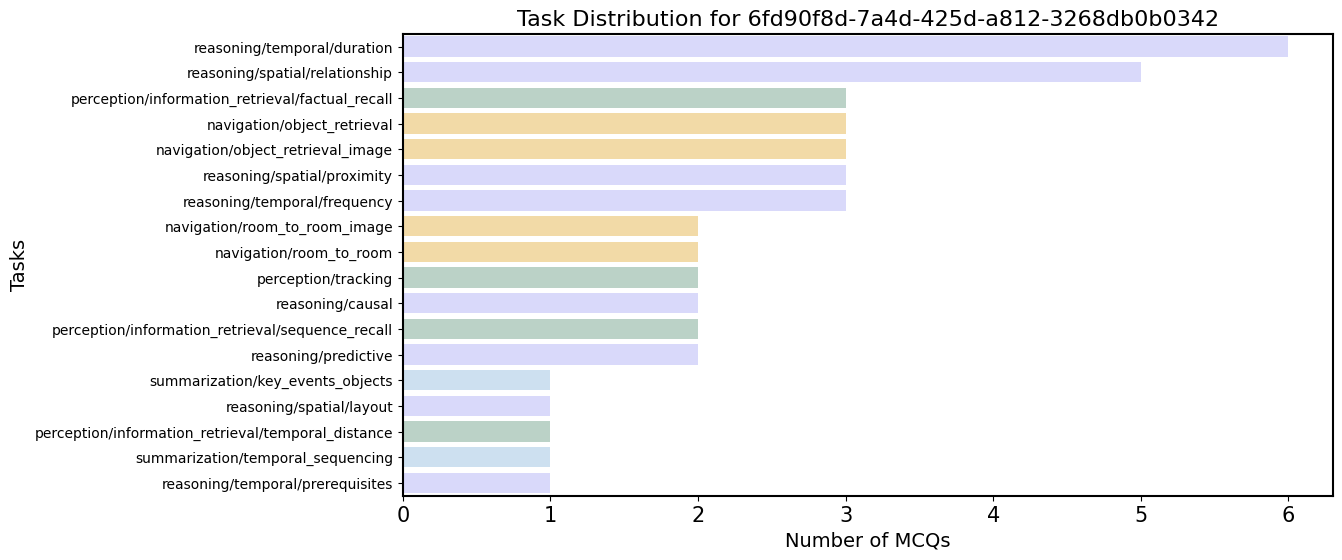

In [7]:
# Plot task distribution for this video
hv_utils.plot_task_distribution(video_benchmark_data, VIDEO_UID, save_path="../assets/demo/gpt-4o/task_distribution.png")

In [8]:
# Prepare for benchmarking
video_benchmark_data_eval_protocol = hv_utils.get_mcqs_hv_eval_protocol(video_benchmark_data)

## 3. Caption the Extracted Frames

In this section, you will use **GPT-4o** to generate captions for the extracted frames (you may also use other GPT variants if preferred). The steps are as follows:

1. **Ensure you have a valid OpenAI API key** to run these experiments. Add your API key to `../env.json`.  
   **Important:** Never share or commit your API keys to GitHub.

2. **Caption the video** in 1-minute chunks.

In [ ]:
OPENAI_KEY_FILE = "../env.json"

# Define your arguments
SEED = 2023

# Model-related arguments
CAPTION_MODEL = 'gpt-4o'
TEMPERATURE = 0.1
MAX_ANSWER_TOKENS = 768
CAPTION_PROMPT_FILE = '../benchmark/HourVideo/prompts/baseline_evaluations/gpt4-turbo/caption.yaml'
PROMPT_SEQUENCE_DIR = f'../assets/demo/{CAPTION_MODEL}/captioner_image_sequence/' # Save 1-min chunk image sequences for debugging.

# Output saving arguments
CAPTIONS_SAVE_DIR = '../assets/demo/results/socratic_models/'

# Developer arguments (Stick to default values below)
RESET = 1
DEBUG = 0

# Combine these into an argparse.Namespace object
args = argparse.Namespace(
    seed=SEED,
    model=CAPTION_MODEL,
    temperature=TEMPERATURE,
    max_answer_tokens=MAX_ANSWER_TOKENS,
    prompt_file=CAPTION_PROMPT_FILE,
    save_dir=CAPTIONS_SAVE_DIR,
    reset=RESET,
    debug=DEBUG
)

In [10]:
# You will need about $1.20 OpenAI credits for captioning this video @0.5fps [Input tokens ~= (255*NUM_FRAMES)+prompt]
# This will take roughly ~15 mins to run
gpt4_captioner.gpt4_caption(args, VIDEO_UID, video_duration, FRAMES_SAVE_PARENT_DIR, 
                            fps=SAMPLING_FPS, save_prompt_image_sequence=True, prompt_image_sequence_dir=PROMPT_SEQUENCE_DIR, env_json_path=OPENAI_KEY_FILE)

Prining Stats for captioning 6fd90f8d-7a4d-425d-a812-3268db0b0342.mp4
The video duration is 59.97 minutes and we extract 1800 frames for proceesing.
This results in 60 1-minute chunks for captioning.
Each 1-minute chunk contains a maximum of 30 frames for captioning.
Caption completion status => 0.0%.
--------------------------


100%|██████████| 60/60 [13:07<00:00, 13.12s/it]


## 4. Run Question-Answering on HourVideo

In this section, you will use **GPT-4-turbo** to run the question-answering pipeline. The steps are as follows:

1. **Use the generated captions** to form a video representation (world state history).  
2. **Combine the world state history with MCQ tests** from HourVideo to run the question-answering pipeline.

In [ ]:
# Define your arguments as constants
SEED = 2023

# Model-related arguments
QA_MODEL = 'gpt-4-turbo'
TEMPERATURE = 0.1
MAX_ANSWER_TOKENS = 4096

# Prompt-related arguments
QA_PROMPT_FILEPATH = '../benchmark/HourVideo/prompts/baseline_evaluations/gpt-4-turbo/qa_eval.yaml'

# Output saving arguments
CAPTION_RESULTS_DIR = f'{CAPTIONS_SAVE_DIR}/{CAPTION_MODEL}/captions/'
QA_SAVE_DIR = '../assets/demo/results/socratic_models/'

# Developer arguments
RESET = 1
DEBUG = 0

# Combine these into an argparse.Namespace object
args = argparse.Namespace(
    seed=SEED,
    model=QA_MODEL,
    temperature=TEMPERATURE,
    max_answer_tokens=MAX_ANSWER_TOKENS,
    prompt_filepath=QA_PROMPT_FILEPATH,
    hourvideo_json_filepath=BENCHMARK_JSON_PATH,
    hourvideo_images_dir=BENCHMARK_IMAGES_DIR,
    save_dir=QA_SAVE_DIR,
    reset=RESET,
    debug=DEBUG
)


In [ ]:
# This code will read the benchmark file, use the Video uid and captions and return results. This will take about 5 mins to run
gpt4_qa.run_gpt4_qa(args, VIDEO_UID, CAPTION_RESULTS_DIR, env_json_path=OPENAI_KEY_FILE)

100.0% 1-minute chunks captioned for 6fd90f8d-7a4d-425d-a812-3268db0b0342


## 4. Run Evaluation



In [15]:
QA_RESULTS_DIR = f'{QA_SAVE_DIR}/{QA_MODEL}/qa/'
print(QA_RESULTS_DIR)
task_metrics, overall_accuracy = hv_utils.evaluate_one_video(video_benchmark_data_eval_protocol, VIDEO_UID,
                                                        results_dir=QA_RESULTS_DIR,
                                                        label='gpt_answer_extracted')

../assets/demo/results/socratic_models//gpt-4-turbo/qa/


In [16]:
# Print results
hv_utils.print_evaluation_results(task_metrics, overall_accuracy, VIDEO_UID, model_name=f'Caption={CAPTION_MODEL}/QA={QA_MODEL}')

     Evaluation Results for Video: 6fd90f8d-7a4d-425d-a812-3268db0b0342/ Caption=gpt-4o/QA=gpt-4-turbo      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Task Name                                          ┃ Total Questions ┃ Correctly Answered ┃ Accuracy (%) ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ navigation/object_retrieval                        │        3        │         0          │     0.00     │
│ navigation/object_retrieval_image                  │        3        │         0          │     0.00     │
│ navigation/room_to_room                            │        2        │         1          │    50.00     │
│ navigation/room_to_room_image                      │        2        │         1          │    50.00     │
│ perception/information_retrieval/factual_recall    │        3        │         1          │    33.33     │
│ perception/information_retrieval/sequence_recall   │        2        │         1          │    50.00     │
│ perception/information_retrieval/temporal_distance │        1        │         0          │     0.00     │
│ perception/tracking                                │        2        │         2          │    100.00    │
│ reasoning/causal                                   │        2        │         0          │     0.00     │
│ reasoning/predictive                               │        2        │         0          │     0.00     │
│ reasoning/spatial/layout                           │        1        │         0          │     0.00     │
│ reasoning/spatial/proximity                        │        3        │         0          │     0.00     │
│ reasoning/spatial/relationship                     │        5        │         0          │     0.00     │
│ reasoning/temporal/duration                        │        6        │         1          │    16.67     │
│ reasoning/temporal/frequency                       │        3        │         1          │    33.33     │
│ reasoning/temporal/prerequisites                   │        1        │         0          │     0.00     │
│ summarization                                      │        2        │         1          │    50.00     │
│ Overall                                            │       43        │         9          │    20.93     │
└────────────────────────────────────────────────────┴─────────────────┴────────────────────┴──────────────┘

## 5. Interpreting Results and Future Directions

The evaluation results above demonstrate the performance of the GPT-4-based baseline on the HourVideo benchmark, with the overall accuracy highlighting the inherent challenges of understanding and reasoning over hour-long videos.

These findings reveal a significant gap in multimodal capabilities, with current models falling well below human-level performance across tasks including summarization, perception, visual reasoning, and navigation. This highlights the need for advancements in long-context multimodal understanding.

### Future Directions
To bridge this gap, several promising avenues for future research include:
* **Efficient Long-Form Video Models:** Developing efficient models capable of processing extended video contexts.
* **Keyframe Searching Methods:** Creating techniques to identify keyframes based on queries for hour-long videos.
* **Analysis:** Investigating the limitations of current models to understand why they fall short on tasks in HourVideo, providing insights for improvement.


To conclude, we hope that HourVideo will serve as a valuable benchmark for driving innovation in this domain, pushing the boundaries of multimodal research.